### Jeremy Kazimer
#### 5018-1732
#### Assignment #4

---

As always, our import statements:

In [1]:
# Main assignment
import tensorflow as tf

# General
import numpy as np
import scipy.io
import time

# Plotting
import matplotlib.pyplot as plt

Burger's Equation is a PDE and a particularly strange one at that.  Given by the equation

\begin{equation}
u_t + uu_x - \kappa u_{xx} = 0 
\end{equation}

where $u$ is the field of the system, $u_t$ is the first partial derivative with respect to $t$ (time), $u_x$ is the first partial derivative with respect to $x$ (position), $\kappa$ is the diffusion constant, and $u_{xx}$ is the second partial derivative with respect to $x$.  

This poses a problem from the first question of the assignment because it was rather easily able to be made discrete.  That is to say, by the form
\begin{equation}
u_{i + 1} = u_i + u_i' \delta t
\end{equation}

However, since that's not the case, we can solve this numerically via a neural net from [this paper](https://arxiv.org/pdf/1711.10561.pdf) and its [respective GitHub page](https://github.com/maziarraissi/PINNs).  Note that all of the neural net code is from this repository, but I've stripped it of its more technical features so that it more accurately reflect the plain goal here.  It would be rather difficult to build our own neural net from the ground up, but understanding their code there has made it easier to work from the top down.

First, we create a class from the neural network, which has been dubbed a 'Physics Informed Neural Network', or simply a neural network that's indicative of some physical process.  Note that all of our constants are set to $1$:

In [11]:
class PhysicsInformedNN:
    def __init__(self, x0, u0, layers, dt, q):
        
        '''
            Initial conditions:
            
            lb -> the lower bound of the system.  We can set this arbitrarily to -1
            ub -> the upper bound of the system.  We can set this arbitrarily to +1
            x0 -> the starting x value.  Not arbitrary, but chosen at random
            u0 -> the starting u value.  Not arbitrary, but chosen at random
            layers -> the shape of each layer.
            dt -> the time step.
            q -> how many elements of the total data we take.
        '''
        
        self.lb = -1
        self.ub = 1
        
        self.x0 = x0
        
        self.u0 = u0
        
        self.layers = layers
        self.dt = dt
        self.q = q
        
        '''
            Intialization.  This creates the layers
            for the weights and biases.  This is what allows
            for the neural network to 'learn', so to speak.
            Without them, we would not be able to really
            make this work.  This works only after activation.
        '''
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)     
        
        '''
            Placeholder variables.  We create these so we have them
            to start with.  They're later modified and used
            appropriately for gradients and the like.
        '''
        
        # Placeholder variables
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x0_tf = tf.placeholder(tf.float32, shape=(None, self.x0.shape[1]))
        self.u0_tf = tf.placeholder(tf.float32, shape=(None, self.u0.shape[1]))
        self.dummy_x0_tf = tf.placeholder(tf.float32, shape=(None, self.q))          
        
        '''
            Here, we make a prediction for the base case
            then take the difference between that and the
            actual value so that we have a starting loss.
            This allows for us to minimize!
        '''
        
        self.U0_pred = self.net_U0(self.x0_tf) 
        
        self.loss = tf.reduce_sum(tf.square(self.u0_tf - self.U0_pred))
         
        '''
            This is what reduces loss and maximizes accuracy.
            Consider that the method is the means by which loss is
            minimized.  This is the same as the assignment from last semester.
            The best optimizers don't work with the Pi Zero W due to issues.
        '''
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        '''
            We create an initializer and then start the
            session with this intializer so that
            we can begin calculations on it.
        '''
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        '''
            Also storing this, for demonstration sake.
        '''
        
        self.loss_array = []
        self.time_array = []
    
    # Establish base layers for weights and biases.
    def initialize_NN(self, layers):   
        # Creating empty arrays to store
        # the actual weights and biases
        weights = []
        biases = []
        
        num_layers = len(layers) 
        for l in range(0, num_layers - 1):
            
            # Here, we create weights with a truncated normal distribution.  
            # So, each creation is random.  This allows us to handle the noise
            # of the system, otherwise if everything was weighted 1 or 0 it wouldn't work.
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            
            # We set the biases to start as zeros, but this can be updated as time progresses.
            b = tf.Variable(tf.zeros([1, layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            
            weights.append(W)
            biases.append(b)      
            
        return weights, biases
    
    # Generate random weights.
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        
        # So our distribution exists around a certain
        # average, but varies slightly.
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        
        # This returns a random distribution of this size with mean = 0, std = xavier_stddev.
        # So all values exist around 0, but fluctuate by this std.
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        # This just changes the spacing of X so that it's
        # more uniform to our standard.
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        
        # We iterate over all the layers, weights and biases included.
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            
            # We have a 'tanh' activation.  It accumulates at each step.
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            
        W = weights[-1]
        b = biases[-1]
        
        # We repeat for the last layers, to decide 
        # whether our data has 'activated' or not.
        # In neuron speak, whether this neuron has
        # fired.
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    # We calculate the gradients of a U0 vector.
    def fwd_gradients_0(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x0_tf)[0]
        return tf.gradients(g, self.dummy_x0_tf)[0]
    
    # This is just the equation as describe in the earlier part.
    def net_U0(self, x):
        U = self.neural_net(x, self.weights, self.biases)        
        U_x = self.fwd_gradients_0(U, x)
        U_xx = self.fwd_gradients_0(U_x, x)       
        F = -1*U*U_x + 1*U_xx
        U0 = U - self.dt*F
        return U0
    
    # This is where we actually train the network to try and predict
    # the field vectors! It does it for n times until it reaches the end.
    def train(self, nIter):
        
        # Creating a dict of values to pass into training.
        tf_dict = {self.x0_tf: self.x0, self.u0_tf: self.u0, 
                   self.dummy_x0_tf: np.ones((self.x0.shape[0], self.q))}
        
        
        # Start iterating to train the network.
        print('starting training...')
        for it in range(nIter):
            t0 = time.time()
            
            # Run the training.
            self.sess.run(self.train_op_Adam, tf_dict)
            
            t1 = time.time()
            # I'm storing loss and time taken here.
            self.loss_array.append(self.sess.run(self.loss, tf_dict))
            self.time_array.append(t1 - t0)
            print('{:.2f}% done training!'.format(100*(it + 1)/nIter), '\r', end = '')
    
    # Make a simple prediction with base data.
    def predict(self, x_star):
        
        U0_star = self.sess.run(self.U0_pred, {self.x0_tf: x_star, self.dummy_x0_tf: np.ones((x_star.shape[0], self.q))})        
                    
        return U0_star 

Note that a lot of this code has been stripped away.  Before, there was the inclusion of constants from data files, a third partial derivative, and the like.  A lot of their functionality is designed to get the best result, but that's not really our goal, right? Our goal is to just numerically solve Burger's Equation with TensorFlow.  And so I did! The results from this can be seen below.  There are a lot of variables to keep track of, so I tried to describe them to the best of my ability with docstrings:

In [12]:
'''
Variables: 
q -> some initial condition that I'm not fully sure of.
skip -> the number of indices to skip.  Increasing it speeds up the function at the cost of accuracy
data -> data from the original author.  We need this for their u values.
N0 -> grid size?
layers -> the size of each layer, assuming square.
t_star -> time data.
x_star -> grid data.
u_star -> initial u data.
idx_t -> index corresponding to starting time.
idx_x -> index corresponding to starting position.
x0 -> random starting point in space.
u0 -> random starting point in time-space.
dt -> time step
model -> the PINN.
U0_pred -> testing our model with a prediction.
nIter -> number of training iterations.
'''

data = scipy.io.loadmat('burger_data.mat')

skip = 100
q = 50
N0 = 20
layers = [1, 50, 50, 50, 50, q]
t_star = data['tt'].flatten()[:,None]
x_star = data['x'].flatten()[:,None]
u_star = np.real(data['uu'])
idx_t = 40
idx_x = np.random.choice(u_star.shape[0], N0, replace = False)
x0 = x_star[idx_x,:]
u0 = u_star[idx_x, idx_t][:,None]
dt = np.float(t_star[idx_t + skip] - t_star[idx_t])        
nIter = 150  

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [7]:
# Building the model
model = PhysicsInformedNN(x0, u0, layers, dt, q)
model.train(nIter = nIter)

Device mapping:

starting training...


Great! Our code is accurate, despite the changes we made to the system.  You love to see it.  One thing to note is that we can't really optimize the model because the Pi Zero W only allows TensorFlow version 1.14.1, which doesn't have the necessary libraries.  Further, `tensorflow_probability` has a bunch of functions without these dependencies, but I wasn't able to install it.  You don't love to see it.  Regardless, we can plot a few other things.  Namely, important to the Pi Zero, the average runtimes for the most computationally expensive part of the run, the training:

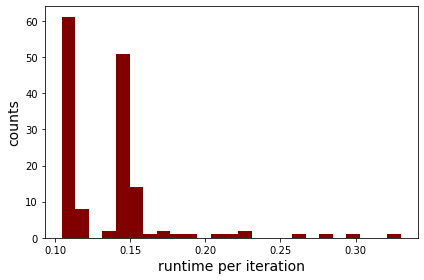

In [8]:
fig, ax = plt.subplots(1, 1)

# We skip the first element because that's like a 'start-up' time and is much greater than the rest.
ax.hist(model.time_array[1:], 25, color = 'maroon');

ax.set_ylabel('counts', fontsize = 14)
ax.set_xlabel('runtime per iteration', fontsize = 14)

fig.tight_layout();

We see that the overall runtime is pretty fast, to be fair.  At least, faster than expected.  This is because the system is so small, though.  We can see that this is vaguely

In [9]:
print('average runtime: t = {:.5f} pm {:.5f} seconds'.format(np.mean(model.time_array[1:]), 
                                                             np.std(model.time_array[1:])/np.sqrt(len(model.time_array[1:]))))

average runtime: t = 0.13657 pm 0.00294 seconds


We can also look at the loss function over each iteration to show that perhaps their original amount was reaching the saturation point.  That is to say, the point by which iteration has nearly a zero reduction in loss:

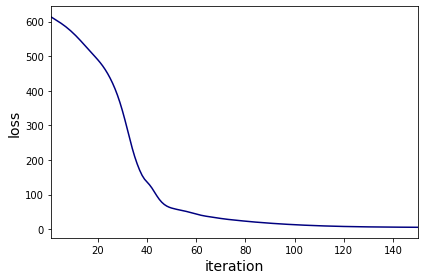

In [10]:
fig, ax = plt.subplots(1, 1)

# We skip the first element because that's like a 'start-up' time and is much greater than the rest.
ax.plot(np.arange(nIter) + 1, model.loss_array, color = 'navy');

ax.set_ylabel('loss', fontsize = 14)
ax.set_xlabel('iteration', fontsize = 14)

ax.set_xlim(1, nIter)

fig.tight_layout();

So, this just means perhaps we don't need as many iterations to cap out on our training model.  Of course, this doesn't translate to predicting on real data, which still has good loss, but it still shows that when optimizing something like this for the Pi Zero W that we can reduce the parameters as much as desired!

_Conclusion_

I think that this assignment was mostly fair.  I would say that Problem 2 was the least fair and perhaps I only understand it somewhat thoroughly because I've experienced machine learning before.  Other than that, the big hassle here is just getting TensorFlow to run on the device, which will be a barrier for many in the future.  I can't even complain about the Pi Zero W here, since most of the limitations I've known for at least a week now.  It does suck that nothing works on the Pi Zero W, but it's good for small scale things, for sure.

---